In [11]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from scannotation import ASAPP
from util._dataloader import DataSet
from util import _topics


import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet()
dl.config = args
dl.initialize_path()
print(dl.inpath)
print(dl.outpath)

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


In [2]:
N=1000
K=10
P=2000
# H,W = sca.simdata(N=1000,K=10,P=2000)
# pd.DataFrame(H).to_csv(fn+'_H.csv.gz',compression='gzip',index=False)
# pd.DataFrame(W).to_csv(fn+'_W.csv.gz',compression='gzip',index=False)
# pd.DataFrame(sca.data.mtx).to_csv(fn+'_X.csv.gz',compression='gzip',index=False)


# H = pd.read_csv(dpath+'_H.csv.gz')
# W = pd.read_csv(dpath+'_W.csv.gz')
X = pd.read_csv(dl.inpath+'_X.csv.gz')
dl.mtx = np.asmatrix(X)
dl.rows = ['c_'+str(i) for i in range(N) ]
dl.cols = ['g_'+str(i) for i in range(P) ]

In [3]:
logging.basicConfig(filename=dl.outpath+'_model.log',
						format='%(asctime)s %(levelname)-8s %(message)s',
						level=logging.INFO,
						datefmt='%Y-%m-%d %H:%M:%S')


In [4]:
asap = ASAPP(adata=dl)
asap.generate_bulk()
asap.factorize()
asap.save_model()

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/model/_dcpmf.py:57: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/model/_dcpmf.py:151: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


In [5]:
dl.outpath += '_sc'
asapsc = ASAPP(adata=dl,experiment_mode='sc')
asapsc.factorize()
asapsc.save_model()

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/model/_dcpmf.py:151: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
figure,axis = plt.subplots(1,2)
sns.heatmap(W,ax=axis[0])
sns.heatmap(H.T,ax=axis[1])


In [6]:
fn = dl.outpath.replace('_sc','')
df_bd = pd.read_csv(fn+'_model_depth.csv.gz')
df_bf = pd.read_csv(fn+'_model_freq.csv.gz')
df_bbeta = pd.read_csv(fn+'_model_beta.csv.gz')
df_btheta = pd.read_csv(fn+'_model_theta.csv.gz')

df_scd = pd.read_csv(fn+'_sc_model_depth.csv.gz')
df_scf = pd.read_csv(fn+'_sc_model_freq.csv.gz')
df_scbeta = pd.read_csv(fn+'_sc_model_beta.csv.gz')
df_sctheta = pd.read_csv(fn+'_sc_model_theta.csv.gz')
df_btheta = df_btheta.rename(columns={'Unnamed: 0':'cell'})
df_bbeta = df_bbeta.rename(columns={'Unnamed: 0':'topic'})
df_sctheta = df_sctheta.rename(columns={'Unnamed: 0':'cell'})
df_scbeta = df_scbeta.rename(columns={'Unnamed: 0':'topic'})

df_bulk_trace= pd.read_csv(fn+'_model_bulk_trace.csv.gz')
df_sc_trace = pd.read_csv(fn+'_sc_model_bulk_trace.csv.gz')
df_scbulk_trace = pd.read_csv(fn+'_model_sc_trace.csv.gz')


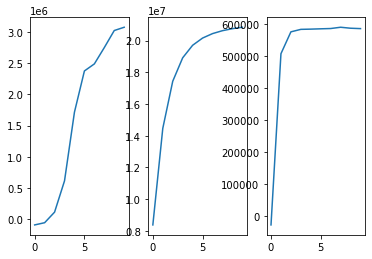

In [7]:
figure,axis = plt.subplots(1,3)
axis[0].plot(df_bulk_trace.iloc[:,1].values)
axis[1].plot(df_scbulk_trace.iloc[:,1].values)
axis[2].plot(df_sc_trace.iloc[:,1].values)

In [8]:
import umap

df_umap= pd.DataFrame()
df_umap['cell'] = df_sctheta['cell']
df_umap['topic_sc'] = [x for x in df_sctheta.iloc[:,1:].idxmax(axis=1)]
df_umap['topic_bulk'] = [x for x in df_btheta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_sctheta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_sc,topic_bulk,umap1,umap2
0,c_0,2,6,0.836688,4.821277
1,c_1,2,6,0.631068,5.554030
2,c_2,2,6,1.063232,4.630949
3,c_3,2,6,3.590227,1.609579
4,c_4,2,6,0.999692,4.374016
...,...,...,...,...,...
995,c_995,6,2,9.971463,3.086107
996,c_996,4,1,2.106724,-0.426923
997,c_997,8,5,5.597038,1.540495
998,c_998,6,2,9.536414,2.935208


Text(0, 0.5, 'UMAP2')

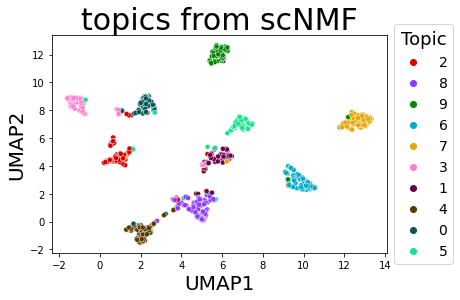

In [9]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_sc'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_sc',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from scNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

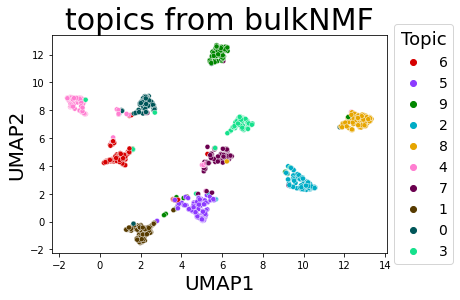

In [10]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(33.0, 0.5, 'bulk')

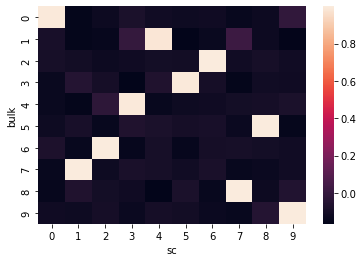

In [12]:
sel_top_genes = list(np.unique(_topics.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.loc[i,sel_top_genes],df_scbeta.loc[j,sel_top_genes])[0,1])
    corr.append(cr)
sns.heatmap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')



Text(33.0, 0.5, 'bulk')

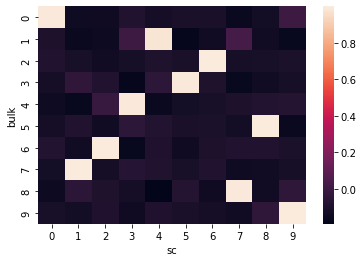

In [13]:
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.iloc[i,1:],df_scbeta.iloc[j,1:])[0,1])
    corr.append(cr)
sns.heatmap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')

In [14]:
df_top = _topics.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=10)
df_top[df_top['Topic']=='k7'].sort_values('Proportion',ascending=False).head(10)


,Topic,GeneType,Genes,Gene,Proportion
707,k7,top_genes,g8,g_1270,10.473033
717,k7,top_genes,g8,g_1305,10.418410
727,k7,top_genes,g8,g_1223,10.227041
737,k7,top_genes,g8,g_1325,10.191191
747,k7,top_genes,g8,g_1378,10.108002
757,k7,top_genes,g8,g_1203,9.973847
767,k7,top_genes,g8,g_1387,9.908537
777,k7,top_genes,g8,g_1295,9.892731
787,k7,top_genes,g8,g_1331,9.653268
797,k7,top_genes,g8,g_1377,9.645471


In [15]:
df_top = _topics.get_topic_top_genes(df_bbeta.iloc[:,1:],top_n=10)
df_top[df_top['Topic']=='k9'].sort_values('Proportion',ascending=False).head(10)

,Topic,GeneType,Genes,Gene,Proportion
909,k9,top_genes,g10,g_1451,7.736289
919,k9,top_genes,g10,g_1485,7.155558
929,k9,top_genes,g10,g_1427,6.763696
939,k9,top_genes,g10,g_1458,6.709283
949,k9,top_genes,g10,g_1405,6.707420
959,k9,top_genes,g10,g_1503,6.680129
969,k9,top_genes,g10,g_1459,6.658717
979,k9,top_genes,g10,g_1486,6.393031
989,k9,top_genes,g10,g_1430,6.380302
999,k9,top_genes,g10,g_1448,6.335400


In [ ]:
df_bf.sort_values('freq',ascending=False)

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


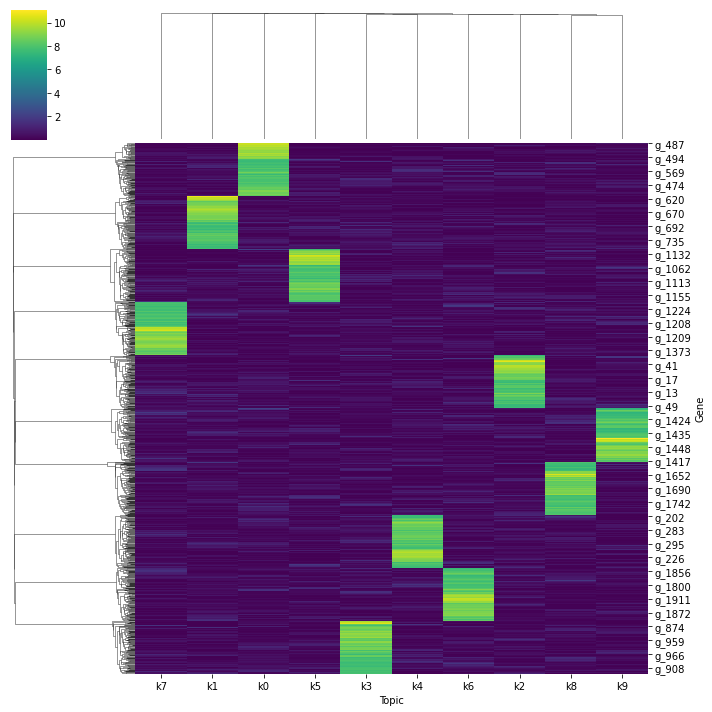

In [16]:
df_top = _topics.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

Text(33.0, 0.5, 'bulk')

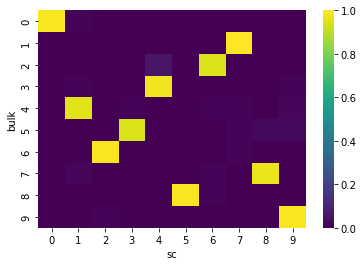

In [17]:

from sklearn.metrics.cluster import contingency_matrix
df_rmatch = pd.DataFrame(contingency_matrix(df_umap.topic_sc,df_umap.topic_bulk))
df_rmatch = df_rmatch.div(df_rmatch.sum(axis=1), axis=0)
sns.heatmap(df_rmatch,cmap='viridis')
plt.xlabel('sc')
plt.ylabel('bulk')
